In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [8]:
sql_path = '../../sql/RecYards/recyards_rb_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

5027


### Split data into train/test/validation

In [9]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

5027


In [10]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [11]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

all_features = features + [target_variable]

In [12]:
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [13]:
X.shape

(5027, 539)

### Use random search to narrow down hyperparameter grid

Fitting estimator with 539 features.
Fitting estimator with 538 features.
Fitting estimator with 537 features.
Fitting estimator with 536 features.
Fitting estimator with 535 features.
Fitting estimator with 534 features.
Fitting estimator with 533 features.
Fitting estimator with 532 features.
Fitting estimator with 531 features.
Fitting estimator with 530 features.
Fitting estimator with 529 features.
Fitting estimator with 528 features.
Fitting estimator with 527 features.
Fitting estimator with 526 features.
Fitting estimator with 525 features.
Fitting estimator with 524 features.
Fitting estimator with 523 features.
Fitting estimator with 522 features.
Fitting estimator with 521 features.
Fitting estimator with 520 features.
Fitting estimator with 519 features.
Fitting estimator with 518 features.
Fitting estimator with 517 features.
Fitting estimator with 516 features.
Fitting estimator with 515 features.
Fitting estimator with 514 features.
Fitting estimator with 513 features.
F

Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
F

C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.7350088192425044, 'gamma': 0.09463324021037844, 'learning_rate': 0.07061018810558387, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 118, 'reg_alpha': 0.41530970389386457, 'reg_lambda': 4.925134553332563, 'subsample': 0.7372891670456634}
Best Score (RMSE): -13.616892977329632
Test R-squared: 0.1391089703419286
Test RMSE: 18.5483
Test MAE: 13.6399


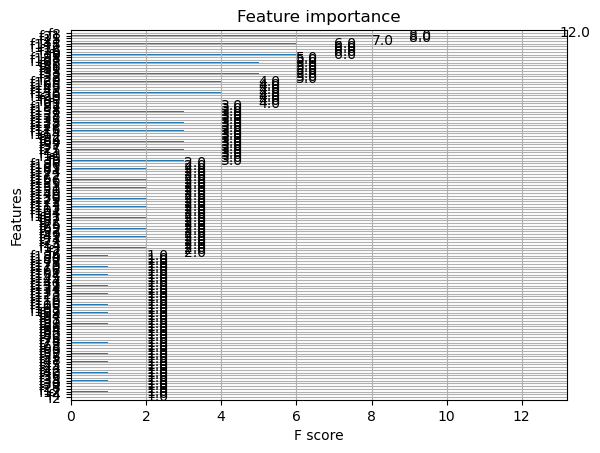

In [14]:
from xgboost import XGBRegressor, plot_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define the XGBoost model
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Create a custom scorer for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom scorers for RMSE and MAE
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Adjust RFECV to remove more features at each step and to find a better subset
rfecv = RFECV(
    estimator=xgb,
    step=1,  # Remove 5 features at each iteration for faster convergence
    cv=kfolds,
    #scoring=rmse_scorer,  # You can try mae_scorer instead for MAE
    scoring=mae_scorer,  # You can try mae_scorer instead for MAE
    min_features_to_select=5,  # Set a minimum number of features to explore
    n_jobs=-1,
    verbose=2
)

# Fit RFECV to the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]
print("Optimal number of features:", rfecv.n_features_)
print("Selected Features:", selected_features)

# Reduce the training and test sets to the selected features
X_train_reduced = rfecv.transform(X_train)
X_test_reduced = rfecv.transform(X_test)

# Define a narrower parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 5),
    'min_child_weight': randint(5, 15),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.1, 5)
}

# RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    cv=kfolds,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=mae_scorer  # Keep the scoring consistent
)

# Fit RandomizedSearchCV on the reduced training data
xgb_random.fit(X_train_reduced, y_train, early_stopping_rounds=10, eval_set=[(X_test_reduced, y_test)], verbose=False)

# Output results
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (RMSE):", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_

# Evaluate the model on the test set
y_pred_test = best_xgb.predict(X_test_reduced)
test_r2_score = best_xgb.score(X_test_reduced, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()


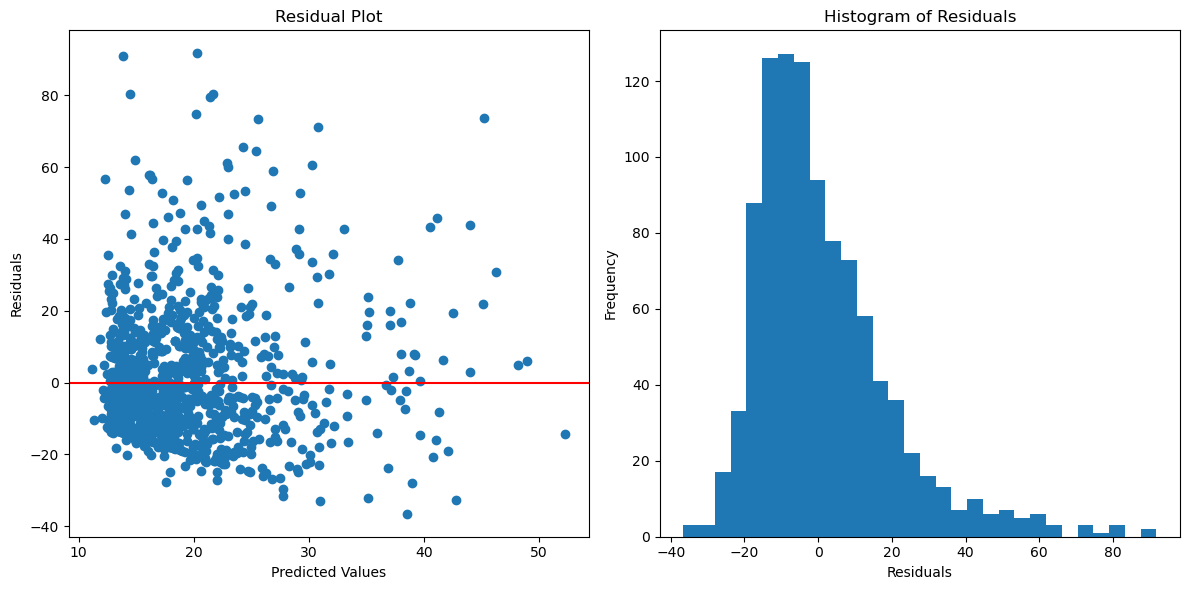

In [15]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

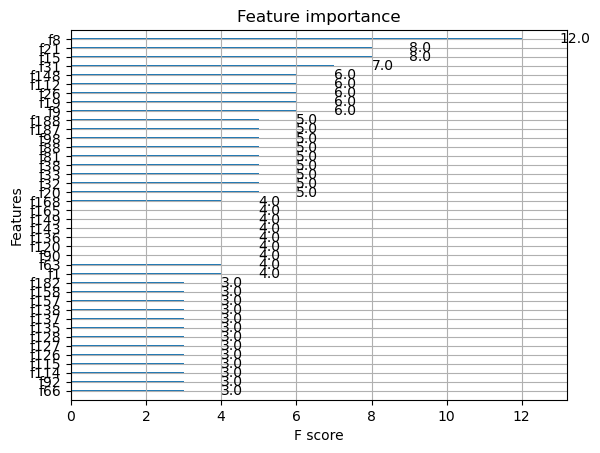

<Figure size 1800x1200 with 0 Axes>

In [16]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

### Persist the best model in the models dir

In [17]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_rb_research.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_rb_research.pkl']

In [18]:
features = selected_features
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_rb_research.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

In [19]:
X_train.columns[rfecv.support_][0]

'3GameYardsPerRecTarget'